In [1]:
%pip install seaborn
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install numpy
%pip install sklearn
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  G

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Subset
from tqdm import tqdm
import os
from PIL import Image

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['file']
        label = self.data.iloc[idx]['label'] - 1
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


# Создаем трансформации
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 32
csv_path = 'all_letters_info.csv'  # Путь к CSV файлу
img_dir = 'all_letters_image'  # Путь к директории с изображениями
# Создаем датасет и даталоадер
dataset = ImageDataset(csv_path=csv_path, img_dir=img_dir, transform=transform)

labels = pd.read_csv(csv_path)['label']
indeces = list(range(len(labels)))
train_val_idx, test_idx = train_test_split(indeces, test_size=0.15, stratify=labels, random_state=42)

train_val_labels = [labels[i] for i in train_val_idx]

train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1765, stratify=train_val_labels, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


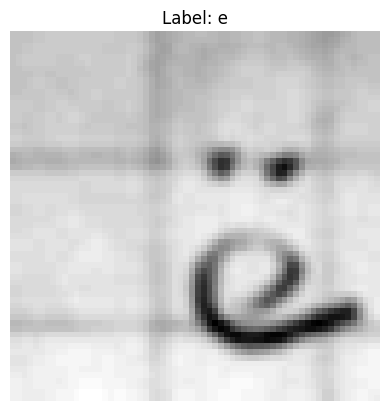

In [4]:
# Получаем первый элемент из датасета
image, label = dataset[332]

# Преобразуем тензор изображения в формат, совместимый с matplotlib
image = image.squeeze(0)  # Убираем канал, так как изображение черно-белое

# Отображаем изображение
plt.imshow(image, cmap='gray')
plt.title(f'Label: {'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'[label-1]}')
# plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(64*64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 33)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def validate(mlp, val_loader):
    mlp.eval()
    total = 0
    correct = 0
    loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            Images = images.to(device)
            Labels = labels.to(device)
            outputs = mlp(Images)
            _, predicted = torch.max(outputs, 1)
            total += Labels.size(0)
            correct += (predicted == Labels).sum().item()
            accuracy = 100 * correct / total
            loss += F.cross_entropy(outputs, Labels).item()
    return accuracy, loss / len(val_loader)

In [8]:
# def train(mlp, train_loader, val_loader, lr, epochs):
#     train_loss_history=[]
#     train_acc_history=[]
#     val_loss_history=[]
#     val_acc_history=[]

#     optimizer = optim.Adam(mlp.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()
#     mlp.train()

#     for epoch in range(epochs):
#         running_loss = 0.0
#         total = 0
#         correct = 0
#         bar = tqdm(train_loader)
#         for images, labels in bar:
#             images = images.to(device)
#             labels.view(-1).long().to(device)

#             optimizer.zero_grad()
#             outputs = mlp(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
#             bar.set_postfix(loss=loss.item())

#         train_loss = running_loss / len(train_loader)
#         train_acc = 100* correct / total
#         train_loss_history.append(train_loss)
#         train_acc_history.append(train_acc)

#         val_acc, val_loss = validate(mlp, val_loader)
#         val_loss_history.append(val_loss)
#         val_acc_history.append(val_acc)

#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}')
#         accuracy = validate(mlp, val_loader)
#         print(f'Validation Accuracy: {accuracy[0]:.2f}%')
#     return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# train_loss, val_loss, train_acc, val_acc = train(model, train_loader, val_loader, lr=0.001, epochs=30)


In [9]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss, label='Train')
# plt.plot(val_loss, label='Val')
# plt.xlabel('Epoch')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_acc, label='Train')
# plt.plot(val_acc, label='Val')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

In [10]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(64*512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 33)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model = CNN_1D().to(device)
print(model)


CNN_1D(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear

In [11]:
criterion = nn.CrossEntropyLoss()
def validate(cnn, val_loader):
    cnn.eval()
    total = 0
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            Images = images.to(device)
            Labels = labels.to(device)
            outputs = cnn(Images)
            total_loss += criterion(outputs, Labels).item()
            _,predicted = torch.max(outputs, 1)
            total += Labels.size(0)
            correct += (predicted == Labels).sum().item()
    loss = total_loss/len(val_loader)
    accuracy = 100 * correct / total
    return loss, accuracy

In [12]:
for im, la in train_loader:
    print(im.view(im.size(0), 1, -1).shape)
    break

torch.Size([32, 1, 4096])


In [13]:
def train(cnn, train_loader, val_loader, lr, epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    cnn.train()
    for epoch in range(epochs):
        correct = 0
        total = 0
        total_loss=0
        bar = tqdm(train_loader)
        for images, labels in bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs= cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
            bar.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        val_loss, val_acc = validate(cnn, val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

train_loss, val_loss, train_acc, val_acc = train(model, train_loader, val_loader, lr=0.001, epochs=30)

Epoch [4/30]:  72%|███████▏  | 223/311 [00:45<00:17,  4.95it/s, loss=2.89]


KeyboardInterrupt: 

In [ ]:
# 1) Определяем 2D-CNN
class CNN_2D(nn.Module):
    def __init__(self, num_classes=33):
        super(CNN_2D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1×64×64 → 32×64×64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 32×32×32

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 64×32×32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 64×16×16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# → 128×16×16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 128×8×8
            nn.Dropout2d(0.5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2) Функция валидации
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_corr, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            total_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            total_corr += (preds == labels).sum().item()
            total_samples += labels.size(0)
    return total_loss / len(dataloader), 100.0 * total_corr / total_samples

# 3) Функция обучения (с сохранением истории)
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=30, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [],  'val_acc': []
    }

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_corr, running_samples = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_corr += (preds == labels).sum().item()
            running_samples += labels.size(0)
            pbar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc  = 100.0 * running_corr / running_samples
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}% | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.2f}%")

    return history

# 4) Запуск обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2d = CNN_2D(num_classes=33).to(device)
history2d = train_model(model2d, train_loader, val_loader, lr=1e-3, epochs=30, device=device)

# 5) Построение графиков
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history2d['train_loss'], label='Train Loss')
plt.plot(history2d['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('2D-CNN Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2d['train_acc'], label='Train Acc')
plt.plot(history2d['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('2D-CNN Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
